In [4]:
%matplotlib inline
import os
from cca_zoo.models import CCA
from cca_zoo.data import generate_covariance_data
from cca_zoo.models import rCCA
from cca_zoo.model_selection import GridSearchCV
from cca_zoo.deepmodels import architectures
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
os.chdir('../raw_data')

#### Functions to load and or write to pickle files

In [5]:
class Files:
    def __init__(self, filename):
        self.file = filename
        
    def write_to_file(self, data):
        with open(self.file, 'wb') as f:
            pickle.dump(data, f) 
        return None
    
    def load_pickle(self):
        data = pd.read_pickle(self.file)
        return data
    
    def load_csv(self, sep, usecols=None):
        data = pd.read_csv(self.file, sep=sep, usecols=usecols)
        return data
        
        
    

In [3]:
os.listdir()

['ALL_GNPS.json',
 'ALL_GNPS_15_12_2021_positive_annotated.pickle',
 'ALL_GNPS_15_12_2021_positive_annotated_classifications.txt',
 'all_spec_embedding.pickle',
 'model_300dim.pkl',
 'mol2vec_embedding.pickle',
 'ms2ds_embeddings_unique_GNPS_15_12_2021.pickle',
 'ms2ds_model_GNPS_15_12_2021.hdf5',
 'plot_validation.py',
 'spec2vec_embeddings_unique_GNPS_15_12_2021.pickle',
 'spec2vec_model_GNPS_15_12_2021.model',
 'spec2vec_model_GNPS_15_12_2021.model.syn1neg.npy',
 'spec2vec_model_GNPS_15_12_2021.model.wv.vectors.npy',
 'spectra_unique_GNPS_15_12_2021.pickle',
 '__pycache__']

In [6]:
#load spec2vec embeddings
path_spec2vec = './all_spec_embedding.pickle'
spec2vec = Files(path_spec2vec).load_pickle()#[:10000]
len(spec2vec)


314318

In [213]:
#load ms2ds embeddings
path_ms2ds = './ms2ds_embeddings_unique_GNPS_15_12_2021.pickle'
ms2ds = Files(path_ms2ds).load_pickle()#[:10000]
len(ms2ds)


20889

In [7]:

#load mol2vec embeddings
path_mol2vec = './mol2vec_embedding.pickle'
mol2vec = Files(path_mol2vec).load_pickle()#[:10000]
len(mol2vec)

314318

In [8]:
#split the dataset
x_train, x_test, y_train, y_test = \
train_test_split(spec2vec, mol2vec, test_size=0.2, random_state=42)

In [9]:
#init CCA
latent_dims=200
linear_cca = CCA(latent_dims=latent_dims)

In [10]:
#fit and transform
train_z1, train_z2 = linear_cca.fit_transform([x_train, y_train])

In [11]:
# extract correlation between the views
train_cor=linear_cca.score([x_train, y_train])
len(train_cor)

200

In [12]:
# transform the test dataset
test_z1, test_z2 = linear_cca.transform([x_test,y_test])
test_cor = linear_cca.score([x_test, y_test])

In [13]:
# create a train pd for plotting
dims = [i for i in range(1,latent_dims+1)] # adding 1 to start from 1
dims
train_cor_df = pd.DataFrame(list(zip(dims,train_cor)),\
                      columns=['latent_dim','cor']) 
train_cor_df.head()

,latent_dim,cor
0,1,0.758863
1,2,0.606353
2,3,0.581601
3,4,0.545333
4,5,0.514477


In [14]:
# create a test pd for plotting
dims = [i for i in range(1,latent_dims+1)]

test_cor_df = pd.DataFrame(list(zip(dims,test_cor)),\
                      columns=['latent_dim','cor']) 
test_cor_df.head()

,latent_dim,cor
0,1,0.760999
1,2,0.607071
2,3,0.579508
3,4,0.539711
4,5,0.504775


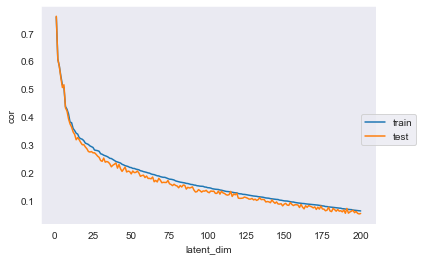

In [18]:
fig, ax = plt.subplots()
sns.set_style('dark')
dfs = [train_cor_df,test_cor_df]
for df in dfs:
    sns.lineplot(data = df, x='latent_dim',y='cor',ax=ax)
fig.legend(labels=['train', 'test'], loc='center right')
plt.show()


In [ ]:
#Think of importing plot_validation 